In [2]:
#import All Lib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Import All Module Needs
from sklearn.pipeline import Pipeline                                 #
from sklearn.preprocessing import LabelEncoder,StandardScaler         # Digunakan untuk Data Transformation
from sklearn.ensemble import RandomForestClassifier                   # Standart Algoritma Random Forest
from sklearn.ensemble import AdaBoostClassifier                       # Algoritma Random Forest with AdaBoostClassifier
from sklearn.feature_selection import SelectKBest,f_classif           # Algortima Random Forest with Feature Selection
from sklearn.model_selection import StratifiedKFold                   # Algoritma Random Forest Stratified Sampling
from sklearn.metrics import accuracy_score, classification_report     # Impor Function akurasi dan classification reportnya
from sklearn.model_selection import train_test_split, cross_val_score # Function Caross Validation dan Split Data
from imblearn.combine import SMOTETomek                               # Balancing Data Metod Hybird

In [3]:
# Load data Stroke CSV
file = ('dataset/stroke_dataset.csv')
data = pd.read_csv(file)
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
#Merubah Data kedalam bentuk Frame
df = pd.DataFrame(data)

In [5]:
#Cek Duplikasi dan Cara handelnya jika terdapat duplikasi
df.duplicated().sum()

0

In [6]:
#Cek Mising Value dan Penanganannya
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [7]:
#Tercatat Ada 201 mising value pada kolom BMI, Maka kita akan isi dengan Rata - rata
avg = df['bmi'].mean()
df['bmi'] = df['bmi'].fillna(avg)
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [8]:
#Mising value sudah Selesai, Lanjut untuk menghapus kolom "ID"
df = df.drop(['id'], axis=1)
df.shape

(5110, 11)

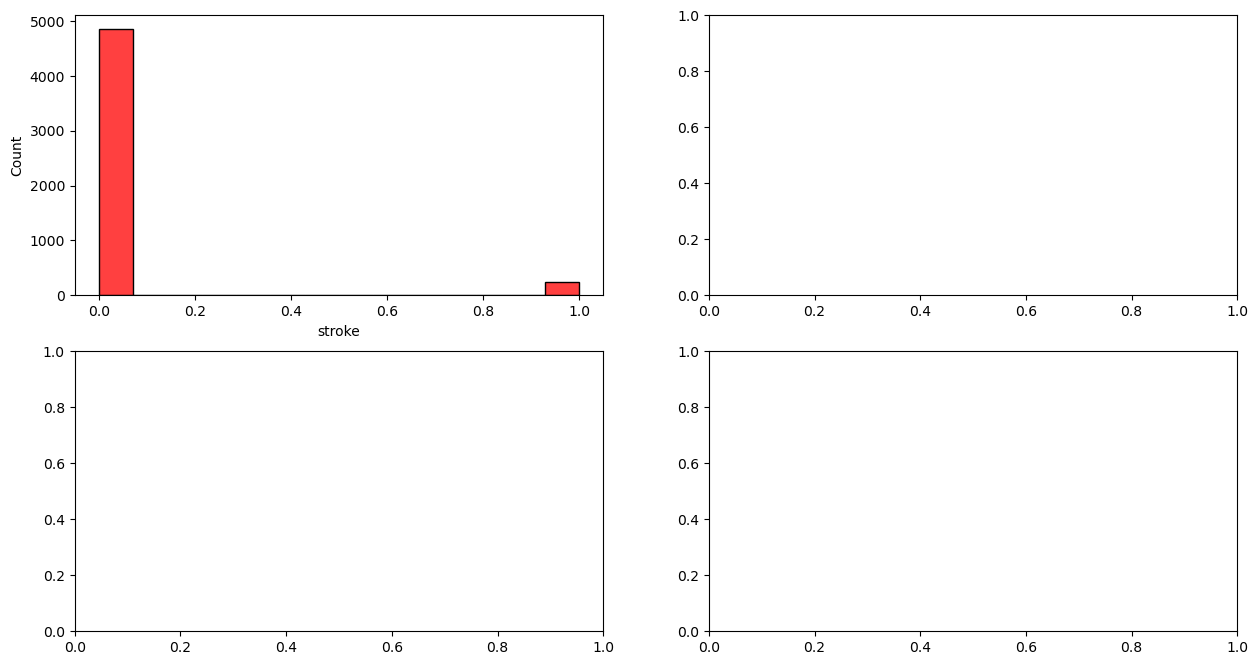

In [9]:
#Visuali Data sebelumm Imbalance
fig, axes = plt.subplots(2,2,figsize=(15,8))

sns.histplot(data = df, x='stroke', ax = axes[0,0], color = 'red') # Menampilkan Data Orang yang Terkena Stroke
plt.show()

In [10]:
#Transformasi Data dari nominal ke numerik
encode = LabelEncoder()

df['gender'] = encode.fit_transform(df['gender'].values)
df['ever_married'] = encode.fit_transform(df['ever_married'].values)
df['work_type'] = encode.fit_transform(df['work_type'].values)
df['Residence_type'] = encode.fit_transform(df['Residence_type'].values)
df['smoking_status'] = encode.fit_transform(df['smoking_status'].values)
print(df.head())

   gender   age  hypertension  heart_disease  ever_married  work_type  \
0       1  67.0             0              1             1          2   
1       0  61.0             0              0             1          3   
2       1  80.0             0              1             1          2   
3       0  49.0             0              0             1          2   
4       0  79.0             1              0             1          3   

   Residence_type  avg_glucose_level        bmi  smoking_status  stroke  
0               1             228.69  36.600000               1       1  
1               0             202.21  28.893237               2       1  
2               0             105.92  32.500000               2       1  
3               1             171.23  34.400000               3       1  
4               0             174.12  24.000000               2       1  


In [11]:
#Identifikasi Variabel bebas dan Terikat
X = df.drop(['stroke'], axis=1)
y = df['stroke']

#Penerpana Balancing Data

sampled = SMOTETomek(random_state=42)
X_sampled, y_sampled = sampled.fit_resample(X, y)

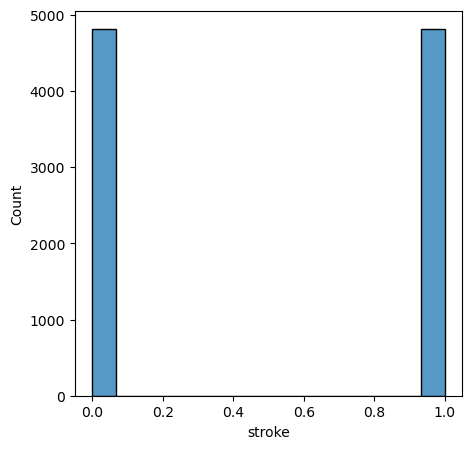

In [12]:
# Menampil Keseimbanagan Data bagian Variabel Terikat (y)

fig = plt.subplots(figsize = (5,5))
sns.histplot(data = y_sampled)
plt.show()

In [13]:
#Cek bayak data setelah Balancing
print(f"Total Data Setelah Balancing Data   = {X_sampled.shape,y_sampled.shape}")

Total Data Setelah Balancing Data   = ((9626, 10), (9626,))


In [14]:
#Proses Split Data
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size= 0.2,
                                                    random_state=42,
                                                    shuffle=True
                                                   )

In [15]:
# Proses Penerapan Algoritma Random Forest

# Weighted Random Forest atau rfw
rfw      = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
y_rfw    = rfw.fit(X_train, y_train).predict(X_test)
skor_rfw = cross_val_score(rfw, X_train, y_train, cv=5)
print(f"Hasil Akurasi dari Weighted Random Forest adalah              = {accuracy_score(y_test, y_rfw)} dengan Standar Deviasinya {skor_rfw.std():0.2f} dan mean {skor_rfw.mean():0.2f}")

# Random Forest with Feature Selection atau rfwfs
rfwfs = Pipeline([
    ('feature_selection', SelectKBest(f_classif, k=5)),   # Memilih top 5 features
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])
y_rfwfs = rfwfs.fit(X_train, y_train).predict(X_test)
skor_rfwfs = cross_val_score(rfwfs, X_train, y_train, cv=5)
print(f"Hasil Akurasi dari Random Forest with Feature Selection adalah = {accuracy_score(y_test, y_rfwfs)} dengan Standar Deviasinya {skor_rfwfs.std():0.2f} dan mean {skor_rfwfs.mean():0.2f}")

Hasil Akurasi dari Weighted Random Forest adalah = 0.9543094496365524 dengan Standar Deviasinya 0.00 dan mean 0.94


Hasil Akurasi dari Random Forest with Feature Selection adalah = 0.9236760124610592 dengan Standar Deviasinya 0.00 dan mean 0.92


In [21]:

# Random Forest With Stratified Sampling atau rfwss
rfwss            = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stratified_rfwss = RandomForestClassifier(n_estimators=100, random_state=42)
y_rfwss          = stratified_rfwss.fit(X_train, y_train).predict(X_test)
skor_rfwss       = cross_val_score(stratified_rfwss, X_train, y_train, cv=rfwss)
print(f"Hasil Akurasi dari Random Forest with Stratified Sampling adalah = {accuracy_score(y_test, y_rfwss)} dengan Standar Deviasinya {skor_rfwss.std():0.2f} dan mean {skor_rfwss.mean():0.2f}")

# Random Forest With Ada BoostUsing RandomForest as base estimator in AdaBoost
rfwb      = AdaBoostClassifier(
            estimator=RandomForestClassifier(n_estimators=50, random_state=42),
            n_estimators=100, random_state=42)
y_rfwb    = rfwb.fit(X_train, y_train).predict(X_test)
skor_rfwb = cross_val_score(rfwb, X_train, y_train, cv=5)
print(f"Hasil Akurasi dari Random Forest with Ada Boost adalah            = {accuracy_score(y_test, y_rfwb)} dengan Standar Deviasinya {skor_rfwss.std():0.2f} dan mean {skor_rfwb.mean():0.2f}")

# Random Forest with Parallelization atau rfwp
rfwp      = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
y_rfwp    = rfwp.fit(X_train, y_train).predict(X_test)
skor_rfwp = cross_val_score(rfwp, X_train, y_train, cv=5)
print(f"Hasil Akurasi dari Random Forest with Parallelization adalah      = {accuracy_score(y_test, y_rfwp)} dengan Standar Deviasinya {skor_rfwp.std():0.1f} dan mean {skor_rfwp.mean():0.1f}")
print("\n")

Hasil Akurasi dari Random Forest with Stratified Sampling adalah = 0.952232606438214 dengan Standar Deviasinya 0.00 dan mean 0.94


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\ProgramDa

Hasil Akurasi dari Random Forest with Ada Boost adalah            = 0.9553478712357217 dengan Standar Deviasinya 0.00 dan mean 0.94
Hasil Akurasi dari Random Forest with Parallelization adalah      = 0.952232606438214 dengan Standar Deviasinya 0.0 dan mean 0.9


